(spectra)=

# Using the Spectra

This notebook will introduce how to pull the raw and processed spectra for single objects. First we'll import the `load_and_plot_spectra` function from the `slsne` package.

In [1]:
from slsne.spectra import load_and_plot_spectra
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

Now we can load all the spectra for a given object and choose if we want the `raw` spectra returned, or the spectra that have been `processed`. The processing involving telluric removal, redshift correction, extinction removal, normalising flux to 1, and remapping and interpolating onto a wavelength grid running from 3000-9000 Angstrom.

This function returns a dictionary of each individual spectra containing:

- 'filename'     - the name of file
- 'mjd'          - MJD of when the spectra was obtained
- 'wavelength'   - wavelength array
- 'flux'         - flux array
- 'error'        - error array (if available otherwise returns None)

    
The function can also generate and save a PDF of the spectra if plot is set to True

In [2]:
# Obtain all the spectra for 2018lfe
sn_name = '2018lfe'

#choosing if we want the raw or processed spectra
flux_type='processed'
spectra_dict = load_and_plot_spectra(sn_name, flux_type=flux_type, output_dir='.', plot=False)

And now we plot

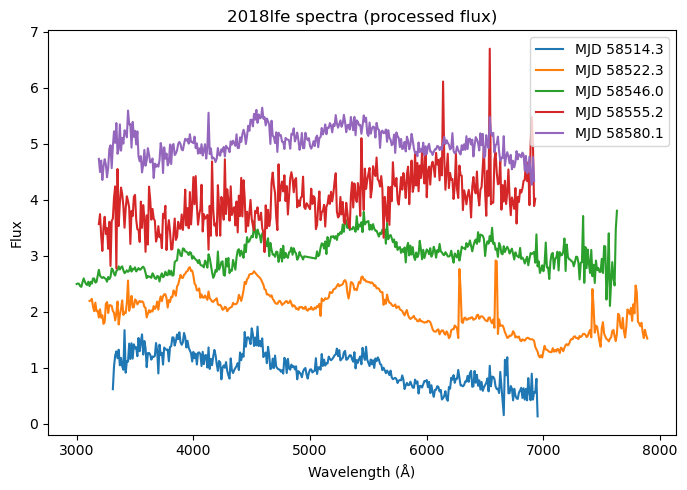

In [3]:
# Sort by MJD
spectra_dict.sort(key=lambda x: x['mjd'])

# Calculate a global median flux for scaling the offsets
all_flux_values = np.concatenate([s['flux'] for s in spectra_dict])
global_median_flux = np.nanmedian(all_flux_values)
if global_median_flux == 0:
    global_median_flux = 1.0  # avoid division by zero


plt.figure(figsize=(7, 5))

for i, s in enumerate(spectra_dict):
    mask = np.isfinite(s['wavelength']) & np.isfinite(s['flux'])
    plt.plot(s['wavelength'][mask], s['flux'][mask] + i*global_median_flux,
            label=f"MJD {s['mjd']:.1f}")

plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.title(f'{sn_name} spectra ({flux_type} flux)')
plt.tight_layout()
plt.legend()

## Average Spectra

Now we can load the average spectra of SLSNe in different phase bins.

First import `load_average_spectra`.

Then we run the function and choose whether we want to group the phases by scaled phases from `explosion`, or unscaled phases from `peak`.

In [4]:
from slsne.spectra import load_average_spectra

phase_type = 'peak'
averages = load_average_spectra(phase_type=phase_type)

Then we can plot these values

/var/folders/25/nbk8srg96djg_t21h31yz21c8pnf93/T/ipykernel_15702/1946964572.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set2')


Text(0.51, 0.5, 'Scaled Flux')

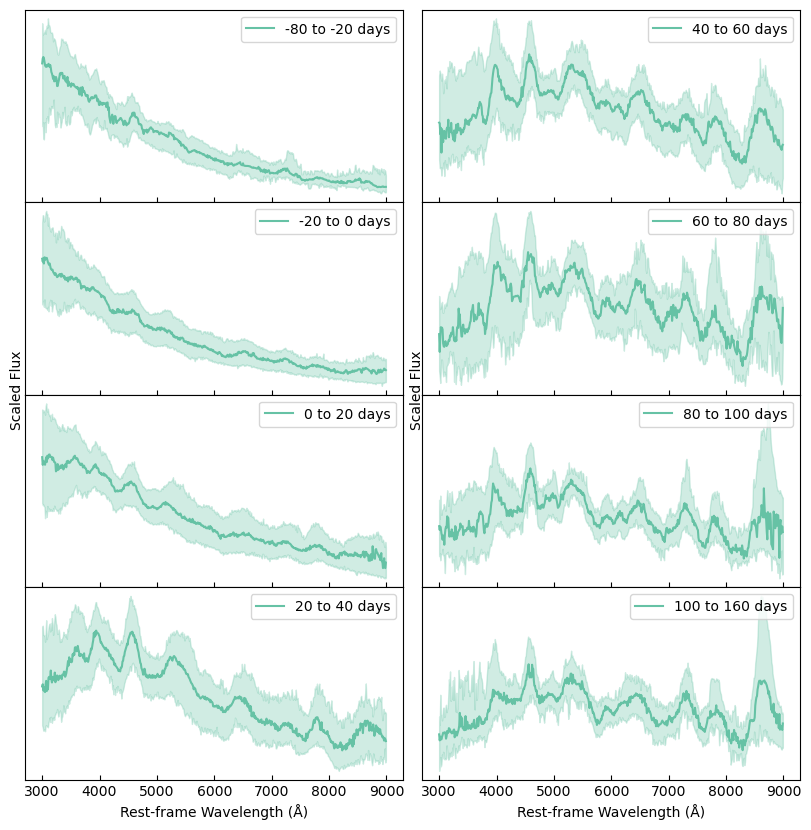

In [5]:
cmap = plt.cm.get_cmap('Set2')

# Prepare figure and grid layout (same as original)
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2, figure=fig)

fig_combos = [
    [0, 0], [1, 0], [2, 0], [3, 0],
    [0, 1], [1, 1], [2, 1], [3, 1]
]

# Loop over spectra
for i, (averages, ax_pos) in enumerate(zip(averages, fig_combos)):
    ax = fig.add_subplot(gs[ax_pos[0], ax_pos[1]])

    bin_min, bin_max = averages['bin_edges']
    wl = averages['wavelength']

    # plotting the median spectra
    ax.plot(wl, averages['median'], label=f'{bin_min} to {bin_max} days', color=cmap(0))
    # plotting the 1sigma spread in flux
    ax.fill_between(wl, averages['percentile16'], averages['percentile84'], alpha=0.3, color=cmap(0))

    ax.legend()
    ax.set_yticks([])
    ax.tick_params(axis='x', direction='in')

    if ax_pos[0] == 3:
        ax.set_xlabel('Rest-frame Wavelength (Å)')

fig.subplots_adjust(wspace=0.05, hspace=0)

# Shared y-axis labels (matching original)
fig.text(0.11, 0.5, 'Scaled Flux', va='center', rotation='vertical')
fig.text(0.51, 0.5, 'Scaled Flux', va='center', rotation='vertical')


## Velocities

Velocities were derived for the spectra using the Fe II 5169 feature based on the code and methodology outlined in  Liu et al. (2017)  and  Modjaz et al. (2016).

We start by importing the function needed, and then choosing whether to plot with respect to [hases from peak, or scaled phases from explosion.]

Text(0, 0.5, 'Velocity (km s$^{-1}$)')

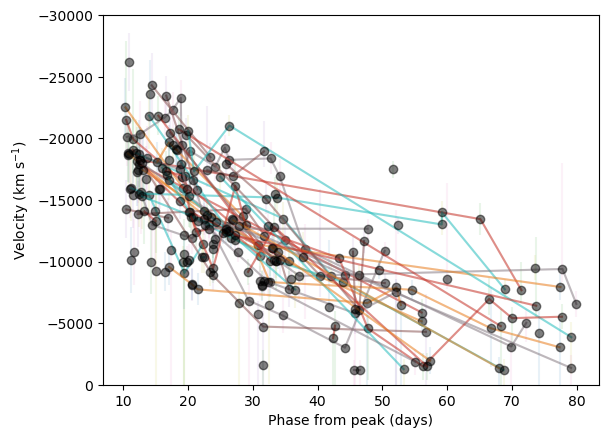

In [6]:
from slsne.spectra import get_velocities

velocities = get_velocities()

# uncomment for phases from peak or from explosion
phase_column = 'Phase_peak'
# phase_column = 'Phase_exp'

# Looping through the velocities for each event
for obj in velocities.Object.unique():
    sn_vel = velocities[velocities['Object']==obj]

    plt.errorbar(sn_vel[phase_column], sn_vel['Best_v'], yerr=(sn_vel['Lower_e'],sn_vel['Upper_e']), alpha=0.1)
    plt.errorbar(sn_vel[phase_column], sn_vel['Best_v'], alpha=0.5)
    plt.errorbar(sn_vel[phase_column], sn_vel['Best_v'], fmt='o', color='k', alpha=0.5)
        
# Saving individual plots 
plt.ylim(0,-30000)
plt.xlabel(f'{phase_column} (days)')
plt.ylabel('Velocity (km s$^{-1}$)')